## Continuous Reactor 
In this example we will illustrate how Cantera can be used to simulate a Continuously Stirred Tank Reactor (CSTR), also interchangeably referred to as a Perfectly Stirred Reactor or a Well Stirred Reactor, a Jet Stirred Reactor or a Longwell Reactor (there may well be more "aliases").

A cartoon of such a reactor is shown below:

<img src="images/stirredReactorCartoon.png" alt="Cartoon of a Stirred Reactor" style="width: 300px;"/>

### Simulation of a CSTR/PSR/WSR 
As the figure illustrates, this is an open system (unlike a Batch Reactor which is isolated). P, V and T are the reactor's pressure, volume and temperature respectively. The mass flow rate at which reactants come in is the same as that of the products which exit; and these stay in the reactor for a characteristic time $\tau$, called the *residence time*. This is a key quantity in sizing the reactor and is defined as follows:

\begin{equation*}
\tau = \frac{m}{\dot{m}}
\end{equation*}

where $m$ is the mass of the gas

In [1]:
import pandas as pd
import time
import cantera as ct

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 2.6.0a4


### Import modules and set plotting defaults

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.style.use("seaborn-pastel")

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

### Define the gas
In this example, we will work with $nC_{7}H_{16}$/$O_{2}$/$He$ mixtures, for which experimental data can be found in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001). We will use the same mechanism reported in the paper. It consists of 1268 species and 5336 reactions

In [3]:
gas = ct.Solution("../data/galway.yaml")

For species OHV, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

For species CHV, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  107.5046684
	Value computed using high-temperature polynomial: 107.34847808033334



### Define initial conditions
#### Inlet conditions for the gas and reactor parameters

In [4]:
# Inlet gas conditions
reactor_temperature = 925  # Kelvin
reactor_pressure = 1.046138 * ct.one_atm  # in atm. This equals 1.06 bars
inlet_concentrations = {"NC7H16": 0.005, "O2": 0.0275, "HE": 0.9675}
gas.TPX = reactor_temperature, reactor_pressure, inlet_concentrations

# Reactor parameters
residence_time = 2  # s
reactor_volume = 30.5 * (1e-2) ** 3  # m3

#### Simulation parameters

In [5]:
# Simulation termination criterion
max_simulation_time = 50  # seconds

### Reactor arrangement

We showed a cartoon of the reactor in the first figure in this notebook; but to actually simulate that, we need a few peripherals. A mass-flow controller upstream of the stirred reactor will allow us to flow gases in, and in-turn, a "reservoir" which simulates a gas tank is required to supply gases to the mass flow controller. Downstream of the reactor, we install a pressure regulator which allows the reactor pressure to stay within. Downstream of the regulator we will need another reservoir which acts like a "sink" or capture tank to capture all exhaust gases (even our simulations are environmentally friendly !). This arrangment is illustrated below

<img src="images/stirredReactorCanteraSimulation.png" alt="Cartoon of a Stirred Reactor" style="width: 600px;"/>

#### Initialize the stirred reactor and connect all peripherals

In [6]:
fuel_air_mixture_tank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirred_reactor = ct.IdealGasReactor(gas, energy="off", volume=reactor_volume)

mass_flow_controller = ct.MassFlowController(
    upstream=fuel_air_mixture_tank,
    downstream=stirred_reactor,
    mdot=stirred_reactor.mass / residence_time,
)

pressure_regulator = ct.PressureController(
    upstream=stirred_reactor, downstream=exhaust, master=mass_flow_controller
)

reactor_network = ct.ReactorNet([stirred_reactor])

In [7]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(gas, extra=["t"])

# Set the maximum simulation time
max_simulation_time = 50  # seconds

In [8]:
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_simulation_time:
    t = reactor_network.step()

    # We will store only every 10th value. Remember, we have 1200+ species, so there will be
    # 1200+ columns for us to work with
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(stirred_reactor.thermo.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()

print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

Simulation Took 42.59s to compute, with 1245 steps


## Plot the results

As a test, we plot the mole fraction of $CO$ and see if the simulation has converged. If not, go back and adjust max. number of steps and/or simulation time

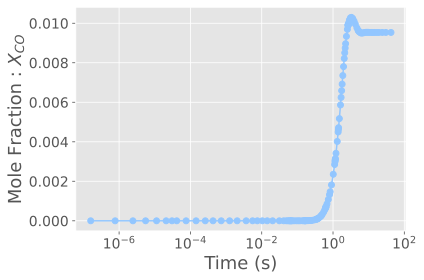

In [9]:
plt.figure()
plt.semilogx(time_history.t, time_history("CO").X, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Mole Fraction : $X_{CO}$");

## Illustration : Modeling experimental data
### Let us see if the reactor can reproduce actual experimental measurements

We first load the data. This is also supplied in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001) as an excel sheet

In [10]:
experimental_data = pd.read_csv("../data/zhangExpData.csv")
experimental_data.head()

,T,NC7H16,O2,CO,CO2
0,500,0.00507,0.0293,0.000000,0.000000
1,525,0.00492,0.0286,0.000000,0.000000
2,550,0.00466,0.0285,0.000000,0.000000
3,575,0.00416,0.0263,0.000243,0.000101
4,600,0.00355,0.0233,0.000968,0.000251


In [11]:
# Define all the temperatures at which we will run simulations. These should overlap
# with the values reported in the paper as much as possible
T = [650, 700, 750, 775, 825, 850, 875, 925, 950, 1075, 1100]

# Create a SolutionArray to store values for the above points
temp_dependence = ct.SolutionArray(gas)

Now we simply run the reactor code we used above for each temperature

In [12]:
concentrations = inlet_concentrations

for reactor_temperature in T:

    # We will use concentrations from the previous iteration to speed up convergence
    gas.TPX = reactor_temperature, reactor_pressure, concentrations

    stirred_reactor = ct.IdealGasReactor(gas, energy="off", volume=reactor_volume)
    fuel_air_mixture_tank = ct.Reservoir(gas)
    mass_flow_controller = ct.MassFlowController(
        upstream=fuel_air_mixture_tank,
        downstream=stirred_reactor,
        mdot=stirred_reactor.mass / residence_time,
    )
    pressure_regulator = ct.PressureController(
        upstream=stirred_reactor, downstream=exhaust, master=mass_flow_controller
    )
    reactor_network = ct.ReactorNet([stirred_reactor])

    # Re-run the isothermal simulations
    tic = time.time()
    reactor_network.advance(max_simulation_time)

    toc = time.time()
    print(f"Simulation at T={reactor_temperature}K took {toc-tic:3.2f}s to compute")

    concentrations = stirred_reactor.thermo.X

    temp_dependence.append(stirred_reactor.thermo.state)

Simulation at T=650K took 49.27s to compute
Simulation at T=700K took 31.94s to compute
Simulation at T=750K took 19.57s to compute
Simulation at T=775K took 19.54s to compute
Simulation at T=825K took 26.57s to compute
Simulation at T=850K took 28.18s to compute
Simulation at T=875K took 26.19s to compute
Simulation at T=925K took 23.82s to compute
Simulation at T=950K took 23.77s to compute
Simulation at T=1075K took 26.78s to compute
Simulation at T=1100K took 24.01s to compute


### Compare the model results with experimental data

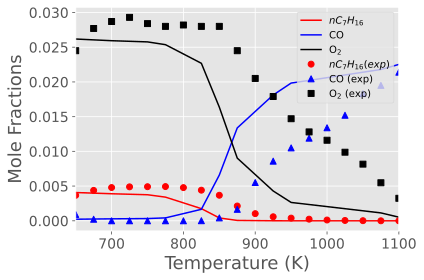

In [13]:
plt.figure()
plt.plot(temp_dependence.T, temp_dependence("NC7H16").X, "r-", label="$nC_{7}H_{16}$")
plt.plot(temp_dependence.T, temp_dependence("CO").X, "b-", label="CO")
plt.plot(temp_dependence.T, temp_dependence("O2").X, "k-", label="O$_{2}$")

plt.plot(
    experimental_data["T"],
    experimental_data["NC7H16"],
    "ro",
    label="$nC_{7}H_{16} (exp)$",
)
plt.plot(experimental_data["T"], experimental_data["CO"], "b^", label="CO (exp)")
plt.plot(experimental_data["T"], experimental_data["O2"], "ks", label="O$_{2}$ (exp)")

plt.xlabel("Temperature (K)")
plt.ylabel(r"Mole Fractions")

plt.xlim([650, 1100])
plt.legend(loc=1);